<a href="https://colab.research.google.com/github/francescomazzolin/stochastic-finance-project/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stochastic Finance Project

Giada Martini

Francesco Mazzolin

Francesco Salvagnin

Nicolas Stecca


## Importing the packages


In [105]:

#!pip install eikon

import eikon as ek
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import fsolve
import importlib
import matplotlib.pyplot as plt

import plotting_functions as mp
import analytical_functions as af

importlib.reload(af)


<module 'analytical_functions' from 'c:\\Users\\paolo\\OneDrive\\Desktop\\SF_Project\\stochastic-finance-project\\analytical_functions.py'>

## Retrieving the data

In [106]:
# Setting up the API key
ek.set_app_key('6e2b6a629eb84c0b859dc5faf22d48f94d85de97')

#### Search parameters


In [121]:

fields = ['TR.CLOSEPRICE.date',
            'TR.CLOSEPRICE', 
            'TR.F.ShrUsedToCalcDilEPSTot','TR.F.MktCap', 'TR.F.DebtTot',
            'TR.CommonName', 'TR.NAICSSector']

start_date = '2024-12-30'

end_date = '2018-12-30'

rolling_window = 252

### Getting different groups of stocks based on their leverage ratio

We will use, at this stage, as a proxy of the value of the assets the sum of the market capitalization of a given firmi and the firm's total debt

In [124]:
#This will get all the stocks in the S&P 500 data for the specified fields
data, err = ek.get_data(instruments=['0#.SPX'], fields = fields)
data.head()
number = data.shape[0]

#Excluding financial sector
data = data[data['NAICS Sector Name'] != 'Finance and Insurance']
post_number = data.shape[0]

print(f'Removed {number - post_number} companies')

Removed 68 companies


c:\Users\paolo\anaconda3\envs\grad\Lib\site-packages\eikon\data_grid.py:255: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
c:\Users\paolo\anaconda3\envs\grad\Lib\site-packages\pandas\core\dtypes\cast.py:1057: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():
c:\Users\paolo\anaconda3\envs\grad\Lib\site-packages\pandas\core\dtypes\cast.py:1081: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():


In [125]:
data['Equity Value'] = data['Close Price'] * data['Shares used to calculate Diluted EPS - Total']

data['Asset Value'] = data['Equity Value'] + data['Debt - Total']

data['Leverage Ratio'] = data['Debt - Total'] / data['Asset Value']

data = data.sort_values(by = 'Leverage Ratio', ascending= False)

print(data.head())

    Instrument                  Date  Close Price  \
162        F.N  2025-01-03T00:00:00Z         9.88   
346     CZR.OQ  2025-01-03T00:00:00Z        32.51   
283      AES.N  2025-01-03T00:00:00Z        13.23   
341    PARA.OQ  2025-01-03T00:00:00Z        10.67   
58        CE.N  2025-01-03T00:00:00Z        66.13   

     Shares used to calculate Diluted EPS - Total  Market Capitalization  \
162                                  4041000000.0     48096718461.658302   
346                                   216000000.0         10092789246.24   
283                                   712000000.0         12890358923.75   
341                                   652000000.0          9828030434.42   
58                                    109379664.0     16912370353.620001   

       Debt - Total        Company Common Name  \
162  149231000000.0              Ford Motor Co   
346   25048000000.0  Caesars Entertainment Inc   
283   26878000000.0                   AES Corp   
341   14602000000.0     

In [126]:
print(data[['Company Common Name', 'Leverage Ratio']].head(100))

           Company Common Name  Leverage Ratio
162              Ford Motor Co         0.78893
346  Caesars Entertainment Inc        0.781038
283                   AES Corp        0.740486
341           Paramount Global        0.677309
58               Celanese Corp        0.654196
..                         ...             ...
382                   LKQ Corp        0.302173
277        Dollar General Corp         0.29886
383            Bunge Global SA        0.295254
363                    UDR Inc        0.290276
111  Occidental Petroleum Corp        0.289104

[100 rows x 2 columns]


In [57]:
#Setting up the function
def get_financial_data(rics, fields, 
                       start_date, end_date,
                       rolling_window):
    #rics = rics
    #Data fields we are interested in: 
      #Total value of equity
      #Total value of debt

    results = []

    df = pd.DataFrame()

    for ric in rics:
        data, err = ek.get_data([ric], fields,
                                {'SDate': f'{start_date}' , 'EDate': f'{end_date}', 'FRQ':'D','period':'FY0'}) #Not sure about period
        if err is None:
            data['RIC'] = ric
            results.append(data)
        else:
            print(f"Error retrieving data for {ric}: {err}")
        
        data['Date'] = pd.to_datetime(data['Date'])
        data = data.sort_values(by='Date').reset_index(drop=True)

        data['Equity_Value'] = data['Close Price'] * data['Shares used to calculate Diluted EPS - Total']

        
        #Computing the log-returns
        prices = data['Close Price']
        log_returns = np.log(prices / prices.shift(1)).dropna()
        data['Log_Returns'] = log_returns
        data.dropna()

        #Compute the rolling-window estimation of the volatility using last year observations
        data['Rolling_Volatility'] = (data['Log_Returns'].rolling(window=rolling_window).std() * np.sqrt(rolling_window) )
        #data['Rolling_Volatility'] = data['Log_Returns'].std() * np.sqrt(252)
        data = data.dropna(subset=['Rolling_Volatility'])
        data = data.dropna(how = 'any')
        


        #Computing total asset values as a sum of the market capitalization + total debt
        #data['Total_value'] = data['Market Capitalization'] + data['Debt - Total']
        data['Total_value'] = (data['Close Price'] * data['Shares used to calculate Diluted EPS - Total']) + data['Debt - Total']
        
        
        data = data.set_index(['Instrument', 'Date'])

    #Combine results into a single DataFrame
        df = pd.concat([df, data])
    #df.drop(columns=['RIC'])

    #Add Total asset value column
    

    return df


#### Choosing the stocks

In [58]:
rics_list = ['AAPL.O', 'META.O', 'BRBI.MI']

#### Retrieving the data

In [59]:
data = get_financial_data(rics_list, fields,
                          start_date, end_date,
                          252)

print(data.head())

print('-'*100)

print(data.tail())

print('-'*100)
#Checks on single stocks
print(data.loc['AAPL.O'].head())

print('-')
print(data.loc[rics_list[1]].describe())

c:\Users\paolo\anaconda3\envs\grad\Lib\site-packages\eikon\data_grid.py:255: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
c:\Users\paolo\anaconda3\envs\grad\Lib\site-packages\eikon\data_grid.py:255: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
c:\Users\paolo\anaconda3\envs\grad\Lib\site-packages\pandas\core\dtypes\cast.py:1057: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():
c:\Users\paolo\anaconda3\envs\grad\Lib\site-packages\pandas\core\dtypes\cast.py:1081: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():


                                      Close Price  \
Instrument Date                                     
AAPL.O     2019-12-31 00:00:00+00:00      73.4125   
           2020-01-02 00:00:00+00:00      75.0875   
           2020-01-03 00:00:00+00:00      74.3575   
           2020-01-06 00:00:00+00:00        74.95   
           2020-01-07 00:00:00+00:00      74.5975   

                                      Shares used to calculate Diluted EPS - Total  \
Instrument Date                                                                      
AAPL.O     2019-12-31 00:00:00+00:00                                   18595652000   
           2020-01-02 00:00:00+00:00                                   18595652000   
           2020-01-03 00:00:00+00:00                                   18595652000   
           2020-01-06 00:00:00+00:00                                   18595652000   
           2020-01-07 00:00:00+00:00                                   18595652000   

                         

c:\Users\paolo\anaconda3\envs\grad\Lib\site-packages\eikon\data_grid.py:255: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
c:\Users\paolo\anaconda3\envs\grad\Lib\site-packages\pandas\core\dtypes\cast.py:1057: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():
c:\Users\paolo\anaconda3\envs\grad\Lib\site-packages\pandas\core\dtypes\cast.py:1081: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():


In [60]:
# import pickle
# import sys
# import os

# current_directory = os.getcwd()

# # Add the current working directory to sys.path
# if current_directory not in sys.path:
#     sys.path.append(current_directory)
#     print('Yes')


# with open('dataframe.pkl', mode= 'rb') as f:

#     data = pickle.load(f)

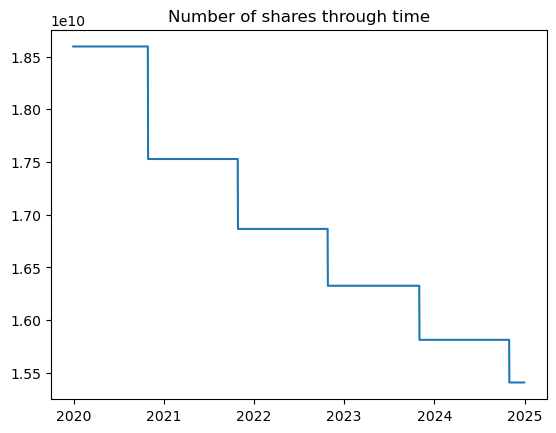

In [61]:
#Plot of outstanding shares 
plt.figure()

plt.title('Number of shares through time')

plt.plot(data.loc['AAPL.O']['Shares used to calculate Diluted EPS - Total'])

plt.show()


## Computing the value of the asset and its volatility

In [62]:
# df_k = pd.DataFrame()

# for ric in rics_list:
#     df = data.loc[ric]
#     df = df.reset_index()
#     df['Total_value'] = (df['Close Price'] * df['Shares used to calculate Diluted EPS - Total']) +df['Debt - Total']
#     # Compute log returns and rolling volatility
#     df['Log_Returns'] = np.log(df['Close Price'] / df['Close Price'].shift(1))
#     df['Rolling_Volatility'] = df['Log_Returns'].rolling(window=252).std() 
#     df = df.dropna(subset=['Rolling_Volatility'])
    
#     # Compute total asset value (equity + debt)
#     #df['Total_value'] = df['Market Capitalization'] + df['Debt - Total']
#     df['RIC'] = ric
#     df = df.set_index([f'RIC', 'Date'])
#     df = df.dropna(how='any')

#     # Drop rows with missing data
    

#     df_k = pd.concat([df, df_k])

# data = df_k.copy()

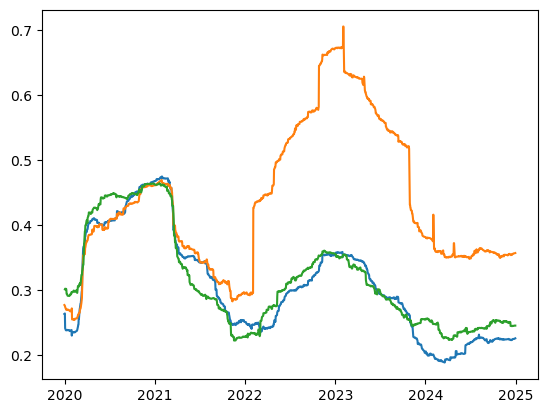

In [63]:
for ric in rics_list:

    plt.plot(data.loc[ric]['Rolling_Volatility'])

In [64]:
# Solve the system for each row
def solve_system(row):
    # Extract parameters from the row
    E = row['Close Price'] * row['Shares used to calculate Diluted EPS - Total'] # Equity (market capitalization)
    sigma_E = row['Rolling_Volatility']  # Rolling volatility as initial guess for sigma_A
    D = row['Debt - Total']          # Debt
    
    row['Risk_Free_Rate'] = 0.04
    r = row['Risk_Free_Rate']        # Assume a risk-free rate column
    
    T = 1                            # Time to maturity (1 year)
    t = 0                            # Current time

    # Define the system of equations
    def system(vars):
        if D > 0:
            A, sigma_A = vars  # Unknowns: Asset value and asset volatility
            equity_value = af.merton_equity(A, D, r, sigma_A, T, t)
            d1 = (np.log(A / D) + (r + 0.5 * sigma_A**2) * (T - t)) / (sigma_A * np.sqrt(T - t))
            f1 = equity_value - E  # Equation (2)
            f2 = (A / E) * norm.cdf(d1) * sigma_A - sigma_E  # Equation (4)

        else: 

            f1 = E 
            f2 = sigma_E
        return [f1, f2]

    # Initial guesses
    A_guess = row['Total_value']  # Total value (equity + debt)
    sigma_A_guess = row['Rolling_Volatility']  # Rolling volatility

    # Solve the system
    solution = fsolve(system, [A_guess, sigma_A_guess])
    return pd.Series({'A_solution': solution[0], 'sigma_A_solution': solution[1]})

# Apply the solver to the DataFrame
def solve_for_all(df):
    results = df.apply(solve_system, axis=1)
    return pd.concat([df, results], axis=1)


In [65]:
data.isna().sum()

Close Price                                     0
Shares used to calculate Diluted EPS - Total    0
Market Capitalization                           0
Debt - Total                                    0
RIC                                             0
Equity_Value                                    0
Log_Returns                                     0
Rolling_Volatility                              0
Total_value                                     0
dtype: int64

In [66]:
#Computing the asset value and volatility at each point in time
df_with_solutions = solve_for_all(data)
print(df_with_solutions.head())

C:\Users\paolo\AppData\Local\Temp\ipykernel_2184\422696715.py:34: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  solution = fsolve(system, [A_guess, sigma_A_guess])
C:\Users\paolo\AppData\Local\Temp\ipykernel_2184\422696715.py:34: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  solution = fsolve(system, [A_guess, sigma_A_guess])
C:\Users\paolo\AppData\Local\Temp\ipykernel_2184\422696715.py:34: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  solution = fsolve(system, [A_guess, sigma_A_guess])
C:\Users\paolo\AppData\Local\Temp\ipykernel_2184\422696715.py:34: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  solution = fsolve(system, [A_guess, sigma_A_guess])
C:\Users\paolo\AppData\Local

                                      Close Price  \
Instrument Date                                     
AAPL.O     2019-12-31 00:00:00+00:00      73.4125   
           2020-01-02 00:00:00+00:00      75.0875   
           2020-01-03 00:00:00+00:00      74.3575   
           2020-01-06 00:00:00+00:00        74.95   
           2020-01-07 00:00:00+00:00      74.5975   

                                      Shares used to calculate Diluted EPS - Total  \
Instrument Date                                                                      
AAPL.O     2019-12-31 00:00:00+00:00                                   18595652000   
           2020-01-02 00:00:00+00:00                                   18595652000   
           2020-01-03 00:00:00+00:00                                   18595652000   
           2020-01-06 00:00:00+00:00                                   18595652000   
           2020-01-07 00:00:00+00:00                                   18595652000   

                         

In [84]:
#Adding leverage ration

df_with_solutions['Leverage_Ratio'] = df_with_solutions['Debt - Total'] / df_with_solutions['A_solution']

## Computing the relevant quantities of the Merton's model

In [85]:
def compute_additional_metrics(row):
    # Extract inputs from the row
    """
    V = row['Total_value']  # Asset value
    sigma = row['Rolling_Volatility']  # Asset volatility
    """
    V = row['A_solution']
    sigma = row['sigma_A_solution']
    
    K = row['Debt - Total']  # Debt
    row['Risk_Free_Rate'] = 0.01
    r = row['Risk_Free_Rate']
    
    #print(V/K)

    T = 1  # Time to maturity
    t = 0  # Current time
    #M = 1_000_000

    # Compute quantities using the provided functions
    equity_value = af.merton_equity(V, K, r, sigma, T, t)
    debt_value = af.merton_debt(V, K, r, sigma, T, t)
    default_probability = af.default_probability(V, K, r, sigma, T, t)
    #mc_default_probability = af.monte_carlo_merton_2(V, K, r, sigma, T, M)
    # mc_sim = af.monte_carlo_merton_2(V, K, r, sigma, T, M)
    # mc_default_probability = mc_sim[2]
    credit_spread = af.credit_spread_model(V, K, sigma, r, T, t)
    #credit_spread_2 = af.credit_spread_model_new(V, K, sigma, r, T, t)


    # Return results as a Series
    return pd.Series({
        'Merton_Equity_Value': equity_value,
        'Merton_Debt_Value': debt_value,
        'Default_Probability': default_probability,
        #'MC_Default_Probability': mc_default_probability,
        'Credit_Spread': credit_spread
        
    })
#'Credit_Spread_2': credit_spread_2

In [86]:
importlib.reload(af)

#Compute the equity value, debt value and probability of default for each company and at each date
df_with_metrics = df_with_solutions.apply(compute_additional_metrics, axis=1)

#Combine the quantities results with the original dataframe
df_final = pd.concat([df_with_solutions, df_with_metrics], axis=1)

#### Plotting the probability of default through time

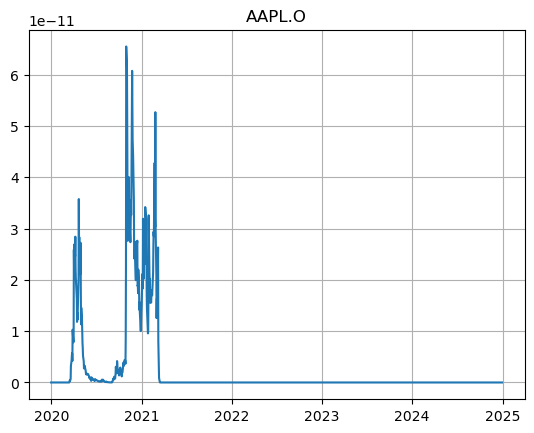

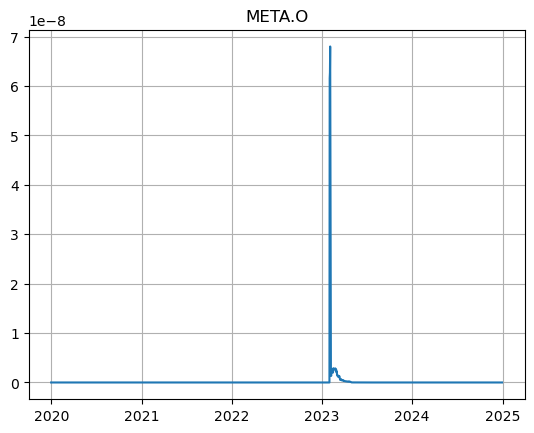

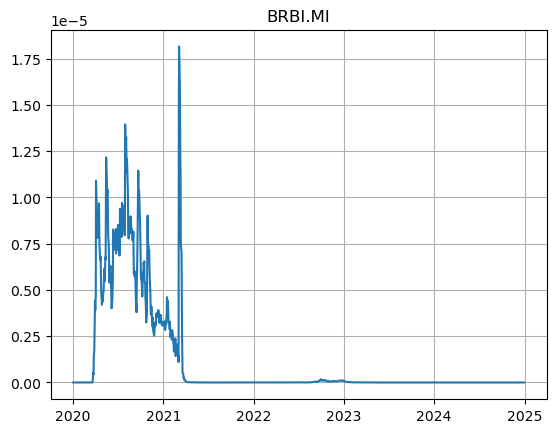

In [87]:
for ric in rics_list:
    plt.figure()

    def_probab = df_final.loc[ric]['Default_Probability']
    plt.plot(def_probab)
    plt.title(f'{ric}')

    plt.grid()

    plt.show()

##### Checking the results

In [88]:
df_final.loc[rics_list[2]].tail()

,Close Price,Shares used to calculate Diluted EPS - Total,Market Capitalization,Debt - Total,RIC,Equity_Value,Log_Returns,Rolling_Volatility,Total_value,A_solution,sigma_A_solution,Leverage_Ratio,Merton_Equity_Value,Merton_Debt_Value,Default_Probability,Credit_Spread
Date,,,,,,,,,,,,,,,,
2024-12-19 00:00:00+00:00,8.957,323640100,3706536975.0,931124000.0,BRBI.MI,2898844375.7,-0.016828,0.245158,3829968375.7,3.793458e+09,0.187347,0.245455,2.871599e+09,9.218592e+08,6.614927e-14,9.992007e-16
2024-12-20 00:00:00+00:00,8.99,323640100,3706536975.0,931124000.0,BRBI.MI,2909524499.0,0.003677,0.245199,3840648499.0,3.804139e+09,0.187541,0.244766,2.882279e+09,9.218592e+08,6.268066e-14,9.992007e-16
2024-12-23 00:00:00+00:00,8.984,323640100,3706536975.0,931124000.0,BRBI.MI,2907582658.4,-0.000668,0.244963,3838706658.4,3.802197e+09,0.187331,0.244891,2.880338e+09,9.218592e+08,5.999912e-14,9.992007e-16
2024-12-27 00:00:00+00:00,9.126,323640100,3706536975.0,931124000.0,BRBI.MI,2953539552.6,0.015682,0.245513,3884663552.6,3.848154e+09,0.188441,0.241966,2.926294e+09,9.218592e+08,5.199091e-14,7.771561e-16
2024-12-30 00:00:00+00:00,9.093,323640100,3706536975.0,931124000.0,BRBI.MI,2942859429.3,-0.003623,0.245485,3873983429.3,3.837474e+09,0.188261,0.24264,2.915614e+09,9.218592e+08,5.501474e-14,8.881784e-16


#### Debugging the credit spread

In [89]:
r = 0.01
T = 1
t = 0

sigma = 0.25


V = 3837473534.932722
#K = 931124000.0 * 2


p_0 = np.exp(-r * (T - t))
K = (V * 0.6) / p_0

# 2) Calculate d1 and d2
d1 = (-(np.log((K*p_0)/V)) + (0 + 0.5*sigma**2) * (T - t)) / (sigma * np.sqrt(T -t))

d2 = d1 - (sigma * np.sqrt(T - t))

# 3) *Defaultable* bond price using Merton's debt formula
#defaultable_bond = K * riskless * norm.cdf(d2) + V * (1 - norm.cdf(d1))

# 4) Credit spread calculation: -1/(T - t) * ln(defaultable_bond / riskless_bond)
credit_spread = -1/(T - t) * np.log(norm.cdf(d2) + (V/(K *p_0))*norm.cdf(-d1))

print(f'Debt-to-value: {K/V}')
print(f'Log: {-(np.log((K*p_0)/V))}')
print(f'Numerator: {(-(np.log((K*p_0)/V)) + (0 + 0.5*sigma**2) * (T - t))}')
print(f'Volatility: {sigma}')
print(f'd1: {d1}')
print(f'First addend: {np.log(norm.cdf(d2) )}' )
print(f'Second addend: {(V/(K *p_0))*norm.cdf(-d1)}')
print(f'Not discounted: {-np.log(norm.cdf(d2) + (V/(K *p_0))*norm.cdf(-d1))}')
print(f'Credit spread: {credit_spread}')

Debt-to-value: 0.6060301002505009
Log: 0.5108256237659907
Numerator: 0.5420756237659907
Volatility: 0.25
d1: 2.168302495063963
First addend: -0.027922564726853342
Second addend: 0.025113065607051538
Not discounted: 0.00242620838220305
Credit spread: 0.00242620838220305


In [90]:
#Test the credit spread model with mock examples
af.credit_spread_model(V = 40, K = 15, sigma = 0.4, r = 0.04, T = 5, t = 0)

0.013587038390588863

## Impact of Volatility on Credit Spread

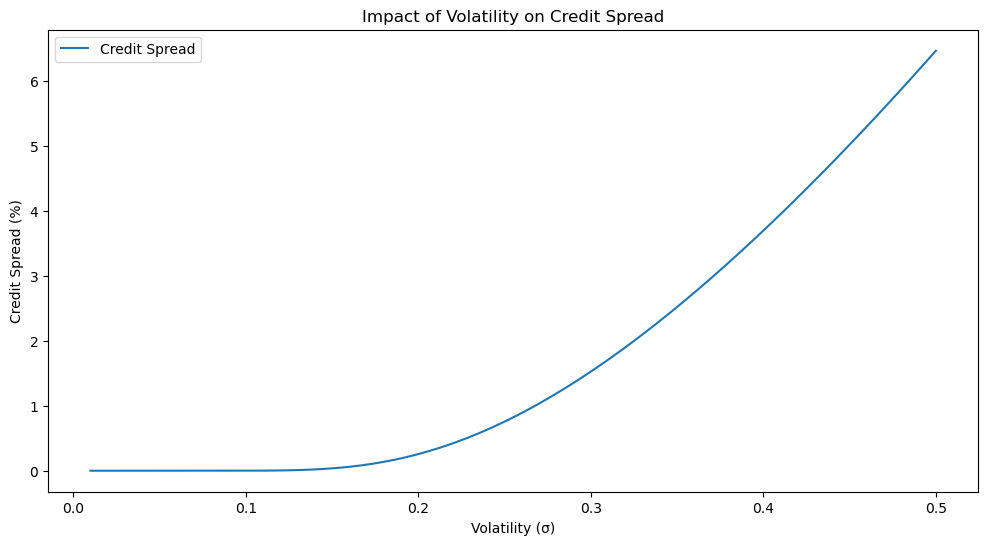

In [91]:
mp.plot_spread_vol(100,60,0,2,0)

## Impact of Time to Maturity on Credit Spread


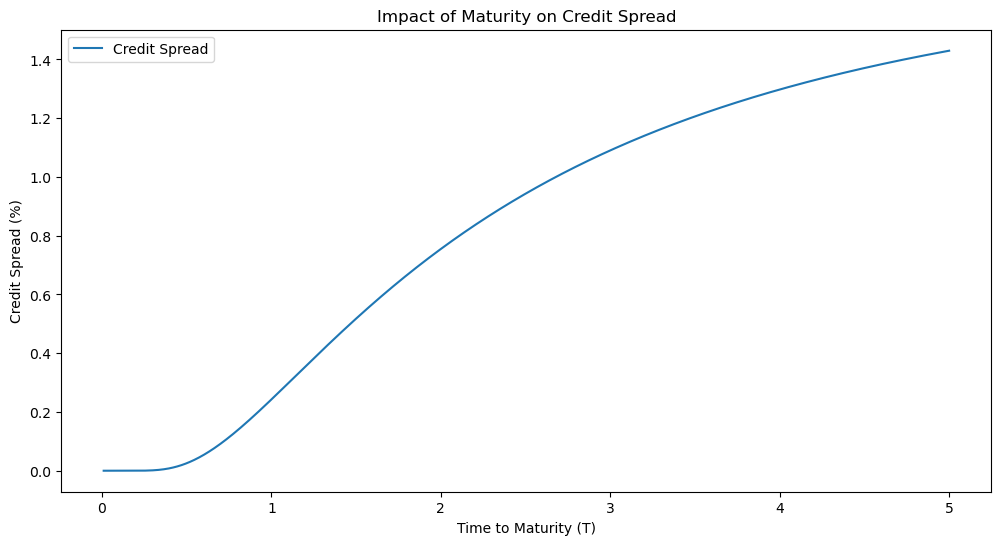

In [92]:
mp.plot_spread_time(100,60,0,2,0)

## Montecarlo simulations of the last observed day of each stock

We need a large number of simulations given the extremely low probabilities we obtain for highly capitalized firms 

In [93]:
data.loc[ric].iloc[-1,:]

Close Price                                            9.093
Shares used to calculate Diluted EPS - Total       323640100
Market Capitalization                           3706536975.0
Debt - Total                                     931124000.0
RIC                                                  BRBI.MI
Equity_Value                                    2942859429.3
Log_Returns                                        -0.003623
Rolling_Volatility                                  0.245485
Total_value                                     3873983429.3
Name: 2024-12-30 00:00:00+00:00, dtype: object

In [94]:
931124000.0 / 3837473535.041267

0.24263984923872237

In [95]:
rics_list 


['AAPL.O', 'META.O', 'BRBI.MI']

In [96]:
importlib.reload(af)
import time as time
mc_probabilities = {}
rics_paths = {}

for ric in rics_list:

    row = df_with_solutions.loc[ric].iloc[-1]
    
    V = row['A_solution']
    sigma = row['sigma_A_solution']
    
    K = row['Debt - Total']  # Debt
    row['Risk_Free_Rate'] = 0.04
    r = row['Risk_Free_Rate']
    
    #print(V/K)

    T = 1  # Time to maturity
    t = 0  # Current time
    M = 1_000_000

    print('-'*100)
    print(f'{ric}\n')
    print(row)
    print('\n')
    
    merton_prob = af.default_probability(V, K, r, sigma, T , t)
    
    
    print(f'\nThe probability of default according to the Merton model is: {merton_prob}\n')
    
    mc_prob = af.monte_carlo_merton(V, K, r, sigma, T, M)
    mc_prob_anti = af.monte_carlo_merton_anti(V, K, r, sigma, T, M)


----------------------------------------------------------------------------------------------------
AAPL.O

Close Price                                                    252.2
Shares used to calculate Diluted EPS - Total             15408095000
Market Capitalization                                3463350367230.0
Debt - Total                                          107525000000.0
RIC                                                           AAPL.O
Equity_Value                                         3885921559000.0
Log_Returns                                                -0.013352
Rolling_Volatility                                          0.225923
Total_value                                          3993446559000.0
A_solution                                      3989230443444.853516
sigma_A_solution                                            0.220073
Leverage_Ratio                                              0.026954
Risk_Free_Rate                                                 

In [97]:
"""
    mc_probabilities[ric] = mc_prob
    print(f'Merton probability is: {merton_prob}')
    print(f'Monte Carlo Merton is: {mc_prob}')

    st = time.time()

    steps = 1000
    batch_size = 10_000
    mc_prob_2 = af.monte_carlo_path_batched(V, K, r, sigma, T, M, steps, batch_size)
    et = time.time()

    print(f'TIme elapsed = {et- st}')
    #rics_paths[ric] = paths
"""
    

"\n    mc_probabilities[ric] = mc_prob\n    print(f'Merton probability is: {merton_prob}')\n    print(f'Monte Carlo Merton is: {mc_prob}')\n\n    st = time.time()\n\n    steps = 1000\n    batch_size = 10_000\n    mc_prob_2 = af.monte_carlo_path_batched(V, K, r, sigma, T, M, steps, batch_size)\n    et = time.time()\n\n    print(f'TIme elapsed = {et- st}')\n    #rics_paths[ric] = paths\n"

In [98]:
# plt.figure()

# ric = rics_list[-1]
# M = 10000
# mc_prob_2, paths = af.monte_carlo_path(V, K, r, sigma, T, M, steps)
# rics_paths[ric] = paths


# paths_sing = rics_paths[ric]

# if mc_prob_2 > 0:

#     plt.axhline(np.log(V))

#     for i in range(paths_sing.shape[0]):

#         plt.plot(paths_sing[i, :], alpha = 0.2)

#     plt.axhline(np.log(K))
#     plt.title(f'A {M} simulations for {ric}')

#     plt.show()

## Ratings of S&P 500

In [99]:
ratings_data, err = ek.get_data(instruments=['0#.SPX'], 
                                fields=['TR.CommonName',
                                        'TR.IssuerRating(IssuerRatingSrc=SPI)',
                                        'TR.IssuerRating(IssuerRatingSrc=SPI,Sdate=-10Y)'])
print(ratings_data.head())

ratings_data, err = ek.get_data(instruments=['0#.SPX'], 
                                fields=['TR.CommonName',
                                        'TR.IssuerRating'])
print(ratings_data.head())

c:\Users\paolo\anaconda3\envs\grad\Lib\site-packages\eikon\data_grid.py:255: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


  Instrument        Company Common Name  Issuer Rating  Issuer Rating
0    POOL.OQ                  Pool Corp           <NA>           <NA>
1    CHRW.OQ  CH Robinson Worldwide Inc           <NA>           <NA>
2      AJG.N  Arthur J. Gallagher & Co.           <NA>           <NA>
3      CNP.N     CenterPoint Energy Inc           <NA>           <NA>
4     AMCR.N                  Amcor PLC           <NA>           <NA>
  Instrument        Company Common Name Issuer Rating
0    POOL.OQ                  Pool Corp           A1+
1    CHRW.OQ  CH Robinson Worldwide Inc           A1+
2      AJG.N  Arthur J. Gallagher & Co.          Baa2
3      CNP.N     CenterPoint Energy Inc          Baa3
4     AMCR.N                  Amcor PLC          Baa2


c:\Users\paolo\anaconda3\envs\grad\Lib\site-packages\eikon\data_grid.py:255: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


In [100]:
ratings_data['Issuer Rating'].value_counts()

Issuer Rating
Baa2            51
Baa1            49
A1+             39
A1              39
                35
P-2             30
A2              25
Baa3            24
A3              20
NR              19
BBB             17
A               13
P-1             12
BBB+            11
Ba1             11
Aa3             10
BBB-             9
WR               9
A-               7
F1               6
A+               6
WD               6
Ba2              6
Discontinued     5
BB+              4
BB               4
F2               4
Aa2              4
P-3              3
Ba3              2
BB-              2
B-               2
B1               2
F3               2
AA-              2
B                2
LGD2 - 20%       1
Aaa              1
LGD4 - 68%       1
(P)Baa3          1
B+               1
LGD5 - 74%       1
LGD5 - 81%       1
(P)A2            1
AA               1
(P)Baa2          1
LGD4 - 54%       1
Name: count, dtype: Int64

In [101]:
ratings_data[ratings_data['Issuer Rating'] == 'B1']

,Instrument,Company Common Name,Issuer Rating
63,DAY.N,Dayforce Inc,B1
346,CZR.OQ,Caesars Entertainment Inc,B1
